#### GA Insert Analysis

This code varies the masked section of pLac to see how it relates to the upper and lower bounds of the promoter's expression.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import time
import itertools

from GA_params_class.GeneticAlgorithm import GeneticAlgorithm

In [2]:
cnn_model_path = '../../Models/CNN_6_1_2.keras'
target_expressions = [0, 1]
precision = 0.001
run_per_mask_length = 20

mask_lengths = np.linspace(1, 150, 20, dtype=int)
mask_sequences = ['N' * mask_length for mask_length in mask_lengths]

In [3]:
plain_mask_results = []

# Initialize tqdm progress bar
total_iterations = len(mask_sequences) * len(target_expressions) * run_per_mask_length
progress_bar = tqdm(total=total_iterations, desc="Processing Mask Lengths")

start_time = time.time()

for mask_length, masked_sequence in zip(mask_lengths, mask_sequences):

    # Run the GA with the masked sequence for high and low expression
    for target_expression in target_expressions:
        for run_id in range(run_per_mask_length):
            ga = GeneticAlgorithm(
                cnn_model_path=cnn_model_path,
                masked_sequence=masked_sequence,
                target_expression=target_expression,
                precision=precision,
                print_progress=False,
                seed=run_id,
            )
            best_sequence, best_prediction = ga.run()

            # Save the plain_mask_results in a dictionary
            plain_mask_results.append({
                'mask_length' : mask_length,
                'target_expression': target_expression,
                'run_id': run_id,
                'best_sequence': best_sequence,
                'best_prediction': best_prediction,
            })

            # Update progress bar
            progress_bar.update(1)
            elapsed_time = time.time() - start_time
            progress_bar.set_postfix({
                "Elapsed": f"{elapsed_time:.2f}s",
                "ETA": f"{(elapsed_time / progress_bar.n) * (total_iterations - progress_bar.n):.2f}s"
            })

# Close progress bar
progress_bar.close()

# Save the plain_mask_results in a dataframe
plain_mask_results_df = pd.DataFrame(plain_mask_results)


Processing Mask Lengths: 100%|██████████| 800/800 [28:59<00:00,  2.17s/it, Elapsed=1739.17s, ETA=0.00s]  


In [4]:
plain_mask_results_df.to_csv('plain_mask_results.csv', index=False)

In [5]:
plain_mask_results_df.head()

,mask_length,target_expression,run_id,best_sequence,best_prediction
0,1,0,0,A,0.306717
1,1,0,1,C,0.306717
2,1,0,2,C,0.306717
3,1,0,3,C,0.306717
4,1,0,4,G,0.306717


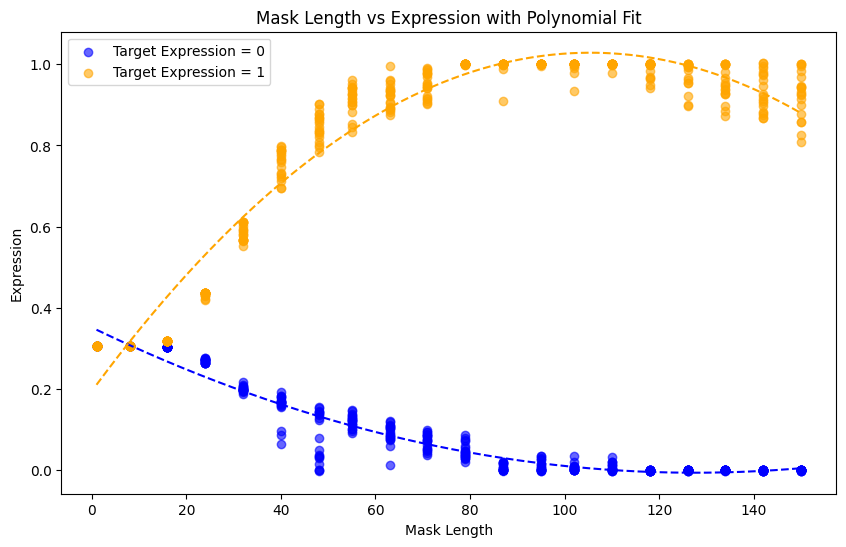

In [8]:
# Filter the data for the two target expressions
data_target_0 = plain_mask_results_df[plain_mask_results_df['target_expression'] == 0]
data_target_1 = plain_mask_results_df[plain_mask_results_df['target_expression'] == 1]

# Polynomial fit for target_expression = 0
coeffs_0 = np.polyfit(data_target_0['mask_length'], data_target_0['best_prediction'], deg=2)
poly_fit_0 = np.poly1d(coeffs_0)
x_0 = np.linspace(data_target_0['mask_length'].min(), data_target_0['mask_length'].max(), 500)
y_0 = poly_fit_0(x_0)

# Polynomial fit for target_expression = 1
coeffs_1 = np.polyfit(data_target_1['mask_length'], data_target_1['best_prediction'], deg=2)
poly_fit_1 = np.poly1d(coeffs_1)
x_1 = np.linspace(data_target_1['mask_length'].min(), data_target_1['mask_length'].max(), 500)
y_1 = poly_fit_1(x_1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(data_target_0['mask_length'], data_target_0['best_prediction'], color='blue', alpha=0.6, label='Target Expression = 0')
plt.scatter(data_target_1['mask_length'], data_target_1['best_prediction'], color='orange', alpha=0.6, label='Target Expression = 1')
plt.plot(x_0, y_0, color='blue', linestyle='--', label=None)
plt.plot(x_1, y_1, color='orange', linestyle='--', label=None)

# Add labels, legend, and title
plt.xlabel('Mask Length')
plt.ylabel('Expression')
plt.title('Mask Length vs Expression with Polynomial Fit')
plt.legend()

# Show the plot
plt.show()